# LogP optimization with ReLeaSE algorithm

In this experiment we will optimized parameters of pretrained generative RNN to produce molecules with values of logP within drug-like region according to Lipinsky rule. We use policy gradient algorithm with custom reward function to bias the properties of generated molecules aka Reinforcement Learninf for Structural Evolution (ReLeaSE) as was proposed in **Popova, M., Isayev, O., & Tropsha, A. (2018). *Deep reinforcement learning for de novo drug design*. Science advances, 4(7), eaap7885.** 

## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

In [4]:
sys.path.append('./release/')

In [5]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR, StepLR
import torch.nn.functional as F

In [26]:
use_cuda = torch.cuda.is_available()
use_cuda

True

In [47]:
import numpy as np
from tqdm import tqdm, trange
import pickle
from rdkit import Chem, DataStructs
from stackRNN import StackAugmentedRNN
from data import GeneratorData 
from utils import canonical_smiles

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

## Setting up the generator

### Loading data for the generator

Data from CHEMBL: a collection of 1,576,904 SMILES. This data will be used to train the SMILES generator.

In [9]:
gen_data_path = './data/chembl_22_clean_1576904_sorted_std_final.smi'

In [10]:
tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']

In [11]:
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter='\t', 
                         cols_to_read=[0], keep_header=True, tokens=tokens)

In [27]:
gen_data.use_cuda

True

## Util functions

**plot_hist** function plots histogram of predicted properties and a vertical line for thershold.

In [16]:
def plot_hist(prediction, n_to_generate):
    prediction = np.array(prediction)
    percentage_in_threshold = np.sum((prediction >= 0.0) & 
                                     (prediction <= 5.0))/len(prediction)
    print("Percentage of predictions within drug-like region:", percentage_in_threshold)
    print("Proportion of valid SMILES:", len(prediction)/n_to_generate)
    ax = sns.kdeplot(prediction, shade=True)
    plt.axvline(x=0.0)
    plt.axvline(x=5.0)
    ax.set(xlabel='Predicted LogP', 
           title='Distribution of predicted LogP for generated molecules')
    plt.show()

**estimate_and_update** function:

1) generates n_to_generate number of SMILES strings

2) filters invalid SMILES

3) predicts logP for valid SMILES

4) plots histogram of predicted logP

5) Returns valid SMILES and their predicted logPs

In [24]:
def estimate_and_update(generator, predictor, n_to_generate):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, predict_len=120)[1:-1])

    sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
    unique_smiles = list(np.unique(sanitized))[1:]
    smiles, prediction, nan_smiles = predictor.predict(unique_smiles, use_tqdm=True)  
                                                       
    plot_hist(prediction, n_to_generate)
        
    return smiles, prediction

## Initializing and training the generator

We will used stack augmented generative GRU as a generator. The model was trained to predict the next symbol from SMILES alphabet using the already generated prefix. Model was trained to minimize the cross-entropy loss between predicted symbol and ground truth symbol. Scheme of the generator when inferring new SMILES is shown below:

<img src="./figures/generator.png">

Initialize stack-augmented generative RNN:

In [48]:
hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'GRU'
lr = 0.001
optimizer_instance = torch.optim.Adadelta

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth, 
                                 use_cuda=use_cuda, 
                                 optimizer_instance=optimizer_instance, lr=lr)

If you want train the model from scratch, uncomment the lines below:

In [49]:
model_path = './checkpoints/generator/checkpoint_biggest_rnn'

Train the SMILES generator, using the `gen_data` defined above. The training is set to 1,500,000 iterations (epochs) which, in my computer (Acer Predator Helios 300 with 1 NVIDIA GEFORCE GTX 1060, 6GB memory), takes ~5h 54min ( approx. 6h), to run only 3% (47,726) of the total of 1,500,000 iterations.

For running all the iterations on my computer it would take ~12,000 minutes, or 200h. Just for testing purposes, I'll run for only 10 epochs.

In [53]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    #losses = my_generator.fit(gen_data, 1500000)
    losses = my_generator.fit(gen_data, 10)

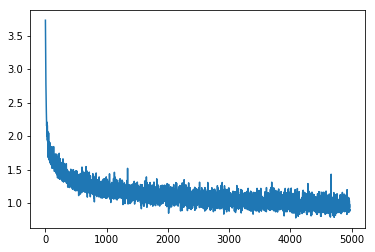

Exception ignored in: <function tqdm.__del__ at 0x0000022802485598>
Traceback (most recent call last):
  File "C:\Users\gmseabra\Miniconda3\envs\unc\lib\site-packages\tqdm\_tqdm.py", line 966, in __del__
    self.close()
  File "C:\Users\gmseabra\Miniconda3\envs\unc\lib\site-packages\tqdm\_tqdm_notebook.py", line 239, in close
    super(tqdm_notebook, self).close(*args, **kwargs)
  File "C:\Users\gmseabra\Miniconda3\envs\unc\lib\site-packages\tqdm\_tqdm.py", line 1158, in close
    if self.disable:
AttributeError: 'tqdm_notebook' object has no attribute 'disable'


In [54]:
plt.plot(losses)

In [ ]:
#my_generator.evaluate(gen_data)

In [ ]:
#my_generator.save_model(model_path)

Alternatively, you can skip the process of training and load the pretrained parameters into the model:

In [55]:
my_generator.load_model(model_path)

## Setting up the predictor

For this demo we will use Recurrent Neural Network, i.e. unidirectional LSTM with 2 layers. The network is trained in 5-fold cross validation manner using the OpenChem toolkit (https://github.com/Mariewelt/OpenChem). In this demo we only upload the pretrained model. The training demo is in *RecurrentQSAR-example-logp.ipynb* file in the same directory. 

In [57]:
! git clone --single-branch --branch develop https://github.com/Mariewelt/OpenChem.git

Cloning into 'OpenChem'...


In [68]:
# sys.path.append('./OpenChem/')
sys.path.append('C:\\Users\\gmseabra\\OneDrive\\source\\repos\\ReLeaSE\\OpenChem')

In [69]:
sys.path

['C:\\Users\\gmseabra\\OneDrive\\source\\repos\\ReLeaSE',
 'C:\\Users\\gmseabra\\Miniconda3\\envs\\unc\\python37.zip',
 'C:\\Users\\gmseabra\\Miniconda3\\envs\\unc\\DLLs',
 'C:\\Users\\gmseabra\\Miniconda3\\envs\\unc\\lib',
 'C:\\Users\\gmseabra\\Miniconda3\\envs\\unc',
 '',
 'C:\\Users\\gmseabra\\Miniconda3\\envs\\unc\\lib\\site-packages',
 'C:\\Users\\gmseabra\\Miniconda3\\envs\\unc\\lib\\site-packages\\win32',
 'C:\\Users\\gmseabra\\Miniconda3\\envs\\unc\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\gmseabra\\Miniconda3\\envs\\unc\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\gmseabra\\Miniconda3\\envs\\unc\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\gmseabra\\.ipython',
 './release/',
 'C:\\Users\\gmseabra\\OneDrive\\source\\repos\\ReLeaSE\\OpenChem']

In [70]:
from rnn_predictor import RNNPredictor

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
predictor_tokens = tokens + [' ']

In [ ]:
path_to_params = './checkpoints/logP/model_parameters.pkl'
path_to_checkpoint = './checkpoints/logP/fold_'

In [ ]:
my_predictor = RNNPredictor(path_to_params, path_to_checkpoint, predictor_tokens)

Here we produce the unbiased distribution of the property:

In [ ]:
smiles_unbiased, prediction_unbiased = estimate_and_update(my_generator,
                                                           my_predictor,
                                                           n_to_generate=10000)

## Biasing the distribution of the generator with reinforcement learning (policy gradient)

We combine the generator and the predictor into a single pipeline. The generator produces new SMILES string, which is then evaluated by the predictor. Based on the obtain prediction and our goal, we assign a numerical reward value and update the parameters of the generator using policy gradient algorithm.

<img src="./figures/rl_pipeline.png">

Policy gradient loss is defined as:
$$
L(S|\theta) = -\dfrac{1}{n}\sum_{i=1}^{|S|} \sum_{j=1}^{length(s_i)} R_i\cdot \gamma^i \cdot \log p(s_i|s_0 \dots s_{i-1}\theta),
$$

where $R_i$ is the reward obtained at time step $i$ $\gamma$ is the discount factor and $p(s_i|s_0 \dots s_{i-1}, \theta)$ is the probability of the next character given the prefix, which we obtain from the generator. 

In our case the reward is the same for every time step and is equal to the reward for the whole molecule. Discount factor $\gamma$ is a number close to $1.0$ (it could be $1.0$).

### Optimizing logP to be in drug like region

In [ ]:
from reinforcement import Reinforcement

Making a copy of the generator that will be optimized

In [ ]:
my_generator_max = StackAugmentedRNN(input_size=gen_data.n_characters, 
                                     hidden_size=hidden_size,
                                     output_size=gen_data.n_characters, 
                                     layer_type=layer_type,
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=stack_width, stack_depth=stack_depth, 
                                     use_cuda=use_cuda, 
                                     optimizer_instance=optimizer_instance, lr=lr)

my_generator_max.load_model(model_path)

In [ ]:
# Setting up some parameters for the experiment
n_to_generate = 200
n_policy_replay = 10
n_policy = 15
n_iterations = 60

In [ ]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

The reward function we will use here is the following:

$$
R =  \begin{cases} 11.0, & \mbox{if } 1.0 < \log P < 4.0 \\ 1.0, & \mbox{otherwise}  \end{cases}
$$

In [ ]:
def get_reward_logp(smiles, predictor, invalid_reward=0.0):
    mol, prop, nan_smiles = predictor.predict([smiles])
    if len(nan_smiles) == 1:
        return invalid_reward
    if (prop[0] >= 1.0) and (prop[0] <= 4.0):
        return 11.0
    else:
        return 1.0

In [ ]:
x = np.linspace(-5, 12)
reward = lambda x: 11.0 if ((x > 1.0) and (x < 4.0)) else 1.0
plt.plot(x, [reward(i) for i in x])
plt.xlabel('logP value')
plt.ylabel('Reward value')
plt.title('Reward function for logP optimization')
plt.show()

In [ ]:
RL_logp = Reinforcement(my_generator_max, my_predictor, get_reward_logp)

In [ ]:
rewards = []
rl_losses = []

In [ ]:
for i in range(n_iterations):
    for j in trange(n_policy, desc='Policy gradient...'):
        cur_reward, cur_loss = RL_logp.policy_gradient(gen_data)
        rewards.append(simple_moving_average(rewards, cur_reward)) 
        rl_losses.append(simple_moving_average(rl_losses, cur_loss))
    
    plt.plot(rewards)
    plt.xlabel('Training iteration')
    plt.ylabel('Average reward')
    plt.show()
    plt.plot(rl_losses)
    plt.xlabel('Training iteration')
    plt.ylabel('Loss')
    plt.show()
        
    smiles_cur, prediction_cur = estimate_and_update(RL_logp.generator, 
                                                     my_predictor, 
                                                     n_to_generate)
    print('Sample trajectories:')
    for sm in smiles_cur[:5]:
        print(sm)

In [ ]:
smiles_biased, prediction_biased = estimate_and_update(RL_logp.generator, 
                                                       my_predictor,
                                                       n_to_generate=10000)

In [ ]:
sns.kdeplot(prediction_biased, label='Optimized', shade=True, color='purple')
sns.kdeplot(prediction_unbiased, label='Unbiased', shade=True, color='grey')
plt.xlabel('Predicted logP values')
plt.title('Initial and biased distributions of log P')
plt.legend()
plt.show()

### Drawing random molecules

Now we will draw some random compounds from the biased library:

In [ ]:
from rdkit.Chem import Draw

In [ ]:
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Draw
DrawingOptions.atomLabelFontSize = 50
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3

In [ ]:
generated_mols = [Chem.MolFromSmiles(sm, sanitize=True) for sm in smiles_biased]

In [ ]:
sanitized_gen_mols = [generated_mols[i] for i in np.where(np.array(generated_mols) != None)[0]]

In [ ]:
n_to_draw = 20
ind = np.random.randint(0, len(sanitized_gen_mols), n_to_draw)
mols_to_draw = [sanitized_gen_mols[i] for i in ind]
legends = ['log P = ' + str(prediction_biased[i]) for i in ind]

In [ ]:
Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, 
                     subImgSize=(200,200), legends=legends)